In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import random
from sklearn.decomposition import PCA
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

temps_debut = time.time()

# Chemins des fichiers CSV et images
chemin_x_train = r'C:\Users\pc\Documents\Data Scientist\Rakuten_true\Data_rakuten\X_train_update.csv'
chemin_y_train = r'C:\Users\pc\Documents\Data Scientist\Rakuten_true\Data_rakuten\Y_train_CVw08PX.csv'
chemin_images = r'C:\Users\pc\Documents\Data Scientist\Rakuten_true\Data_rakuten\images\image_train'

x_train = pd.read_csv(chemin_x_train, index_col='Unnamed: 0')
y_train = pd.read_csv(chemin_y_train, index_col='Unnamed: 0')

# Equilibrer l'échantillon selon les classes de prdtypecode
df_j1 = pd.merge(x_train, y_train, left_index=True, right_index=True)
tableau_croise = pd.crosstab(index=df_j1['prdtypecode'], columns='Fréquence')
print(tableau_croise)

nombre_echantillons_par_classe = df_j1['prdtypecode'].value_counts().min()

echantillon_equilibre = []
for prdtypecode in df_j1['prdtypecode'].unique():
    indices_prdtypecode = df_j1[df_j1['prdtypecode'] == prdtypecode].index.tolist()
    indices_selectionnes = random.sample(indices_prdtypecode, nombre_echantillons_par_classe)
    echantillon_equilibre.extend(df_j1.loc[indices_selectionnes, ['productid', 'imageid']].values.tolist())

images_select = []

for productid, imageid in echantillon_equilibre:
    nom_fichier = f"image_{imageid}_product_{productid}.jpg"
    chemin_image = os.path.join(chemin_images, nom_fichier)
    if os.path.isfile(chemin_image):
        images_select.append([productid, imageid, prdtypecode])

df_images_info = pd.DataFrame(images_select, columns=['productid', 'imageid', 'prdtypecode'])

print(df_images_info.head())  # Afficher les premières lignes du dataframe d'informations sur les images
print("Nombre total d'images sélectionnées :", len(df_images_info))
print(images_select[:10])


col_0        Fréquence
prdtypecode           
10                3116
40                2508
50                1681
60                 832
1140              2671
1160              3953
1180               764
1280              4870
1281              2070
1300              5045
1301               807
1302              2491
1320              3241
1560              5073
1920              4303
1940               803
2060              4993
2220               824
2280              4760
2403              4774
2462              1421
2522              4989
2582              2589
2583             10209
2585              2496
2705              2761
2905               872
    productid     imageid  prdtypecode
0  1858663209  1264480854         1301
1  3728093436  1238372575         1301
2   177637652  1274500877         1301
3  1301755457  1283230880         1301
4  3145383418  1193533798         1301
Nombre total d'images sélectionnées : 20628
[[1858663209, 1264480854, 1301], [3728093436, 123837257

In [2]:
# Enlever les images qui ne sont pas aux bonnes dimensions en entrée
dimensions_images = []
for image_name in images_select:
    nom_fichier = f"image_{imageid}_product_{productid}.jpg"
    chemin_im = os.path.join(chemin_images, nom_fichier)    
    image = cv2.imread(chemin_im)
    hauteur, largeur, _ = image.shape
    dimensions_images.append((hauteur, largeur))

largeurs, hauteurs = zip(*dimensions_images)
frequence_largeurs = Counter(largeurs)
frequence_hauteurs = Counter(hauteurs)
print("Fréquences des largeurs :\n", frequence_largeurs)
print("\nFréquences des hauteurs :\n", frequence_hauteurs)


Fréquences des largeurs :
 Counter({500: 20628})

Fréquences des hauteurs :
 Counter({500: 20628})


In [4]:
temps_debut = time.time()

# extraire les données des images 
largeur_im=100
hauteur_im=100
donnees=[]

for productid, imageid, prdtypecode in images_select:
    nom_fichier = f"image_{imageid}_product_{productid}.jpg"
    chemin_image = os.path.join(chemin_images, nom_fichier)
       
    # Charger l'image en niveaux de gris
    image = cv2.imread(chemin_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    kernelx = cv2.getDerivKernels(1, 0, 3)
    kernely = cv2.getDerivKernels(0, 1, 3)
    prewitt_x = cv2.filter2D(blurred, -1, kernelx[0] * kernelx[1].T)
    prewitt_y = cv2.filter2D(blurred, -1, kernely[0] * kernely[1].T)
    prewitt_cross = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)
    
    contours, _ = cv2.findContours(prewitt_cross, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)

    bounding_boxes = []
    for contour in contours:
        # Trouver les coordonnées de la boîte englobante du contour actuel
        x, y, w, h = cv2.boundingRect(contour)
        # Ajouter les coordonnées de la boîte englobante à la liste
        bounding_boxes.append((x, y, w, h))

    if bounding_boxes:
        bounding_boxes_array = np.array(bounding_boxes)
        min_x, min_y, min_w, min_h = np.min(bounding_boxes_array, axis=0)
        max_x, max_y, max_w, max_h = np.max(bounding_boxes_array, axis=0)
    else:
        # Gérer le cas où bounding_boxes est vide
        min_x, min_y, min_w, min_h = 0, 0, 0, 0
        max_x, max_y, max_w, max_h = 500, 500, 500, 500

    # Extraire la région de l'image couverte par la boîte englobante
    cropped_image = image[min_y:min_y+max_h, min_x:min_x+max_w]
    
    # Redimensionner l'image sans conserver le ratio d'aspect
    image_redim = cv2.resize(cropped_image, (largeur_im, hauteur_im))
    image_redim_rgb = cv2.cvtColor(image_redim, cv2.COLOR_BGR2RGB)
    
    canal_r, canal_g, canal_b = cv2.split(image_redim_rgb)
    rouge=canal_r.flatten().tolist()
    vert=canal_g.flatten().tolist()
    bleu=canal_b.flatten().tolist()

    # Vérifier si le nombre de pixels correspond 
    nb_pixels = len(rouge) + len(vert) + len(bleu)
    if nb_pixels != 3 * largeur_im * hauteur_im:
        print(f"L'image {nom_fichier} ne contient pas le bon nombre de pixels.")
    else:
        # Ajouter les données à la liste
        donnees.append({
            'imageid': imageid,
            'productid': productid,
            'featr': rouge,
            'featv': vert,
            'featb': bleu
        })



In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

colonnes = ['imageid', 'productid', 'featr', 'featv', 'featb']
df_images = pd.DataFrame(donnees, columns=colonnes)
df_images['productid'] = df_images['productid'].astype(str)
df_images['imageid'] = df_images['imageid'].astype(str)

x_train['productid'] = x_train['productid'].astype(str)
x_train['imageid'] = x_train['imageid'].astype(str)

df_jointure1 = pd.merge(x_train, y_train, left_index=True, right_index=True)
df_jointure2 = pd.merge(df_images, df_jointure1, on=['productid', 'imageid'])

# Convertir les listes de pixels en tableaux numpy
df_jointure2['featr'] = df_jointure2['featr'].apply(lambda x: np.array(x))
df_jointure2['featv'] = df_jointure2['featv'].apply(lambda x: np.array(x))
df_jointure2['featb'] = df_jointure2['featb'].apply(lambda x: np.array(x))

# Fusionner les tableaux numpy de chaque canal de couleur pour former une seule image par échantillon
df_jointure2['image'] = df_jointure2.apply(lambda row: np.dstack((row['featr'], row['featv'], row['featb'])) / 255.0, axis=1)

# Séparer les images et les labels
X = np.stack(df_jointure2['image'].values)  # Tableau numpy contenant toutes les images
y = df_jointure2['prdtypecode'].values  # Tableau numpy contenant les labels

# Encodage des labels si nécessaire (par exemple, LabelEncoder si vous avez des classes catégorielles)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Affichage des dimensions pour vérification
print("Dimensions de X:", X.shape)
print("Dimensions de y_encoded:", y_encoded.shape)

# Arrêter le compteur de temps
temps_fin = time.time()
temps_execution = temps_fin - temps_debut
print("Temps d'exécution:", temps_execution, "secondes")

Dimensions de X: (20628, 1, 10000, 3)
Dimensions de y_encoded: (20628,)
Temps d'exécution: 1010.0250341892242 secondes


Dimensions de X: (20628, 100, 100, 3)


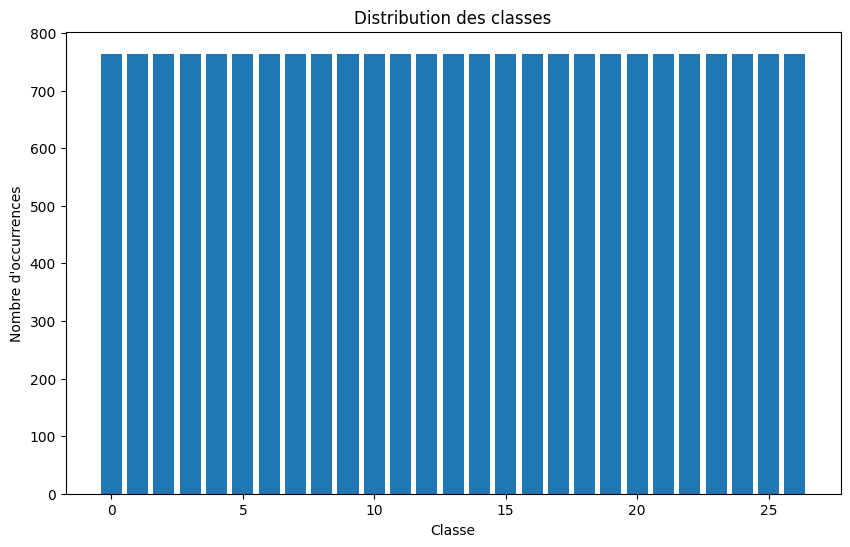

In [10]:
X = np.reshape(X, (20628, 100, 100, 3))
print("Dimensions de X:", X.shape)

unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Distribution des classes')
plt.show()

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Définition des dimensions de l'image
image_height = 100
image_width = 100
num_channels = 3  # Si les images sont en couleur, sinon 1 pour les images en niveaux de gris
num_classes = 27

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

C:\Users\pc\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,739 (1.78 MB)

 Trainable params: 467,739 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=23)

print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)
print("Dimensions de y_train:", y_train.shape)
print("Dimensions de y_test:", y_test.shape)

Dimensions de X_train: (16502, 100, 100, 3)
Dimensions de X_test: (4126, 100, 100, 3)
Dimensions de y_train: (16502,)
Dimensions de y_test: (4126,)


In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 103s 192ms/step - accuracy: 0.3039 - loss: 2.4341 - val_accuracy: 0.2700 - val_loss: 2.5591
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 92s 179ms/step - accuracy: 0.3504 - loss: 2.2316 - val_accuracy: 0.2935 - val_loss: 2.5675
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 91s 176ms/step - accuracy: 0.4086 - loss: 1.9966 - val_accuracy: 0.2937 - val_loss: 2.5434
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 90s 174ms/step - accuracy: 0.4769 - loss: 1.7549 - val_accuracy: 0.2896 - val_loss: 2.6606
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 92s 178ms/step - accuracy: 0.5540 - loss: 1.4907 - val_accuracy: 0.2794 - val_loss: 2.9627
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 89s 173ms/step - accuracy: 0.6312 - loss: 1.2325 - val_accuracy: 0.2727 - val_loss: 3.2439
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 90s 174ms/step - accuracy: 0.7020 - loss: 1.0051 - val_accuracy: 0.2632 - val_loss: 3.6157
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 89s 173ms/step - accuracy: 0.7528 - loss: 

In [17]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.8521 - loss: 0.4703 - val_accuracy: 0.2693 - val_loss: 5.9103
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.8921 - loss: 0.3555 - val_accuracy: 0.2615 - val_loss: 6.5541
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 91s 176ms/step - accuracy: 0.9047 - loss: 0.3082 - val_accuracy: 0.2610 - val_loss: 6.9058
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 94s 181ms/step - accuracy: 0.9103 - loss: 0.2950 - val_accuracy: 0.2605 - val_loss: 7.1425
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 94s 181ms/step - accuracy: 0.9175 - loss: 0.2661 - val_accuracy: 0.2535 - val_loss: 7.2980
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.2539 - loss: 7.2867
Loss: 7.297962188720703
Accuracy: 0.25351428985595703
